In [37]:
import os
import ROOT as r

import ctypes
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt


def biner(edges,bin_widths,histogram):
    if (len(edges)+1!=len(bin_widths)):
        print("Check edges and bin widths array sizes!")
        return
    
    bins=[]
    first_bin = histogram.GetXaxis().GetBinLowEdge(1)
    last_bin = histogram.GetXaxis().GetBinUpEdge(histogram.GetNbinsX())

    for i in range(0,len(edges)):
        n_spaces = int((edges[i] - first_bin)/bin_widths[i])
        bins = np.concatenate((bins,np.linspace(first_bin,edges[i],n_spaces,endpoint=False)))
        first_bin = edges[i]
        if edges[i]==edges[-1]:
            n_spaces = int((last_bin - edges[i])/bin_widths[i+1])
            bins = np.concatenate((bins,np.linspace(edges[i],last_bin,n_spaces,endpoint=False)))
            bins = np.concatenate((bins,[last_bin]))
    return bins
            
def Unpack_Histo(histogram_file):
    bin_content = []
    bin_content_uncer =[]
    for i in range(2,histogram_file.GetNbinsX()+1):
        bin_content.append(histogram_file.GetBinContent(i))
        bin_content_uncer.append(histogram_file.GetBinError(i))
    return np.array(bin_content),np.array(bin_content_uncer)

In [41]:
### Defining class to store information for fit procedure

class mjj_shape :
    def __init__(self,samples,path_to_samples,final_state,histogram="mass_jj"):
        self.final_state = final_state
        self.samples = samples
        self.path_to_samples = path_to_samples
        self.regions = [i for i in os.listdir(path_to_samples)]
        self.dic_of_samples = {}
        self.dic_of_parameters = {}
        self.residuals = {}
        self.x_axis = np.array([])
        
        ### when initialising the object, fill the dictionaries with the samples shape

        for reg in self.regions:
            temp_dic ={}
            for s in samples :

                ### Open the file and get the histogram
                file = r.TFile.Open(path_to_samples+reg+'/'+s)
                hist = file.Get(histogram)
                hist.SetDirectory(0)
                ### Rebin the histogram
                rebining=biner([1500],[250,500],hist)
                nb=len(rebining)-1
                hist=hist.Rebin(nb,"hist",rebining)
                ### Unpack the histogram
                value,uncern = Unpack_Histo(hist)
                if s=="Data.root":
                    x = []
                    for b in range(2,hist.GetNbinsX()+2):
                        x.append(hist.GetBinLowEdge(b))
                    self.x_axis = np.array(x)

                temp_dic[s]={"value":value,"uncern":uncern}
            self.dic_of_samples[reg] = temp_dic

    ### function to calculate the residuals from the samples data

    def calculate_residuals(self,vbf_sample,qcd_sample):
        for reg in self.regions:
            if "CR" in reg:
                residual_val = self.dic_of_samples[reg]["Data.root"]["value"] - self.dic_of_samples[reg][vbf_sample]["value"]
                residual_err = self.dic_of_samples[reg]["Data.root"]["value"] - self.dic_of_samples[reg][vbf_sample]["value"]
                
                for s in self.samples:
                    if  self.final_state not in s and "Data" not in s and "Signal" not in s:
                        residual_val = residual_val - self.dic_of_samples[reg][s]["value"]
                        residual_err = (residual_err**2 + (self.dic_of_samples[reg][s]["uncern"])**2)**0.5
                for i in range(0,len(residual_val)):
                    if residual_val[i]<0:
                        residual_val[i]=0
                
                uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
                residual_val = residual_val/self.dic_of_samples[reg][qcd_sample]["value"]
                residual_err = residual_val*uncer

                self.residuals[reg] = {"value":residual_val,"uncern":residual_err}

    def fit_data(self,reg):
        c = 0
        for i in self.residuals[reg]["value"]:
            if i>0:
                c+=1
            else :
                break
        return self.x_axis[0:c],self.residuals[reg]["value"][0:c],self.residuals[reg]["uncern"][0:c]


In [42]:
Zmm = mjj_shape(["Data.root","Signal_Sherpa.root","Signal_PoPy.root","Zmumu_Sherpa.root","Zmumu_MG.root","ttbar.root","VV.root","Wjets.root","singletop.root"],'/home/diegol/HEP/VBF-Analysis/MuMu/Plots/ParabolicFits/',"Zmumu")
Zee = mjj_shape(["Data.root","Signal_Sherpa.root","Signal_PoPy.root","Zee_Sherpa.root","Zee_MG.root","ttbar.root","VV.root","Wjets.root","singletop.root"],'/home/diegol/HEP/VBF-Analysis/Zee/Plots/ParabolicFits/',"Zee")

Zmm.x_axis

array([ 250.,  500.,  750., 1000., 1250., 1500., 2000., 2500., 3000.,
       3500., 4000., 4500., 5000.])

In [43]:
Zmm.calculate_residuals("Signal_Sherpa.root","Zmumu_MG.root")
Zee.calculate_residuals("Signal_Sherpa.root","Zee_MG.root")
 
#print(Zee.residuals["CRb"]["value"])

x,y,err = Zee.fit_data("CRb")
print(err)
print(y)

[0.84623128 0.8091572  0.68009238 0.59972171 0.71958925 0.71137631
 0.91243266 1.60341847]
[0.83512903 0.80021403 0.67124389 0.59214513 0.70997717 0.69823825
 0.89417794 1.5292161 ]


/tmp/ipykernel_19818/3035737404.py:55: RuntimeWarning: divide by zero encountered in true_divide
  uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
/tmp/ipykernel_19818/3035737404.py:57: RuntimeWarning: invalid value encountered in multiply
  residual_err = residual_val*uncer
/tmp/ipykernel_19818/3035737404.py:55: RuntimeWarning: invalid value encountered in true_divide
  uncer = ((residual_err/residual_val)**2+(self.dic_of_samples[reg][qcd_sample]["uncern"]/self.dic_of_samples[reg][qcd_sample]["value"])**2)**0.5
/tmp/ipykernel_19818/3035737404.py:56: RuntimeWarning: invalid value encountered in true_divide
  residual_val = residual_val/self.dic_of_samples[reg][qcd_sample]["value"]


,a,sigma a,b,sigma b,c,sigma c,sigma ab,sigma ac,sigma bc
0,0.0000003221,0.0000000976,-0.0007070616,0.0001718076,1.0259614871,0.0673159572,-1.6074006002e-11,0.0000000054,-0.0000107516


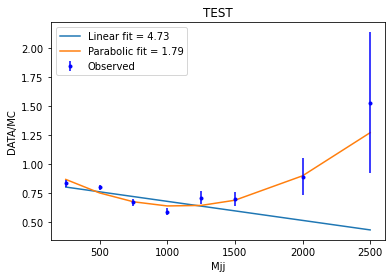

In [17]:
from scipy.optimize import curve_fit
    
def linear_shape(mjj,slope,level):
    return slope*mjj+level

def parabolic_shape(mjj,a,b,c):
    return a*(mjj**2)+b*mjj+c

def chi_square(model, slope, level, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-2))

def chi_square2(model, slope, level,offset, x,y,uncer):
    chi=0
    for i in range(0,len(x)):
        chi+=((y[i]-model(x[i],slope,level,offset))**2)/(uncer[i]**2)
        #print(x[i])
        #print(((y[i]-model(x[i],slope,level))**2)/(uncer[i]**2))
    return (chi/(len(x)-3))

xdata = x
ydata = y



lfit, lcov = curve_fit(linear_shape, xdata, ydata,sigma=err)
dlfit, dlcov = curve_fit(parabolic_shape, xdata, ydata,sigma=err)

plt.plot(xdata,linear_shape(np.array(xdata),lfit[0],lfit[1]))
plt.plot(xdata,parabolic_shape(np.array(xdata),dlfit[0],dlfit[1],dlfit[2]))
plt.errorbar(xdata, ydata,yerr=err,fmt='b.')
plt.legend(["Linear fit = "+str(round(chi_square(linear_shape,lfit[0],lfit[1],xdata,ydata,err),2)),
"Parabolic fit = "+str(round(chi_square2(parabolic_shape,dlfit[0],dlfit[1],dlfit[2],xdata,ydata,err),2)),"Observed"],loc ="upper left")
plt.title("TEST")
plt.xlabel('Mjj') 
plt.ylabel('DATA/MC') 

#plt.savefig(path+"/"+signal+".pdf")

pd.set_option("display.precision", 10)
d = {'a':[dlfit[0]],'sigma a': [np.sqrt(dlcov[0][0])],'b':[dlfit[1]],'sigma b': [np.sqrt(dlcov[1][1])],'c':[dlfit[2]],'sigma c':[np.sqrt(dlcov[2][2])],
    'sigma ab':[dlcov[1][0]],'sigma ac':[dlcov[2][0]],'sigma bc':[dlcov[1][2]]}

df = pd.DataFrame(data=d)


d = {'m':[dlfit[0]],'sigma m': [np.sqrt(dlcov[0][0])],'l':[dlfit[1]],'sigma l': [np.sqrt(dlcov[1][1])],'n':[dlfit[2]],'sigma n':[np.sqrt(dlcov[2][2])],
    'sigma ml':[dlcov[1][0]],'sigma mn':[dlcov[2][0]],'sigma ln':[dlcov[1][2]]}

dl = {'m':[lfit[0]],'sigma m': [np.sqrt(lcov[0][0])],'l':[lfit[1]],'sigma l': [np.sqrt(lcov[1][1])],
    'sigma ml':[dlcov[1][0]]}
dfl = pd.DataFrame(data=dl)

df


In [2]:
from scipy.optimize import curve_fit